## Error estimation

In this notebook, I will show several ways to calculate error bars in hera_pspec, which include:
1. Analytic error bars derived in quadratic estimator formalism. The input covariance will be shown tow options: 
from time average or from autobaseline visibilities   
2. Analytic noise power spectrum, while a input system temperature input needed.

Note the error bars shown in the notebook don't have true meanings, just serve as exmples for tutoring. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

from pyuvdata import UVData
import hera_pspec as hp
from hera_pspec.data import DATA_PATH

/home/phil/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/home/phil/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/home/phil/.local/lib/python3.7/site-packages/hera_sim-0.3.0-py3.7.egg/hera_sim/__init__.py:37: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, c

## Prepare power spectrum

In [3]:
dfile = os.path.join(DATA_PATH, 'zen.all.xx.LST.1.06964.uvA')

# Load into UVData objects
uvd = UVData()
uvd.read_miriad(dfile)

In [4]:
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

In [5]:
# We set the number of samples (integrations) per visibility/frequency/time to be one here
uvd.nsample_array = np.ones_like(uvd.nsample_array)

In [6]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

In [7]:
ds.rephase_to_dset(0)
# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [8]:
baselines = [(24,25), (37,38), (38,39)]
# calculate all baseline pairs from group
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines, exclude_auto_bls=True, 
                                                                 exclude_permutations=True)

### Using default norm:

In [10]:
uvp, uvp_q = ds.pspec(baselines1, baselines2, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400),], input_data_weight='identity',
               norm='I', store_cov=True, cov_models=["time_average","autos"], taper='blackman-harris', verbose=False)

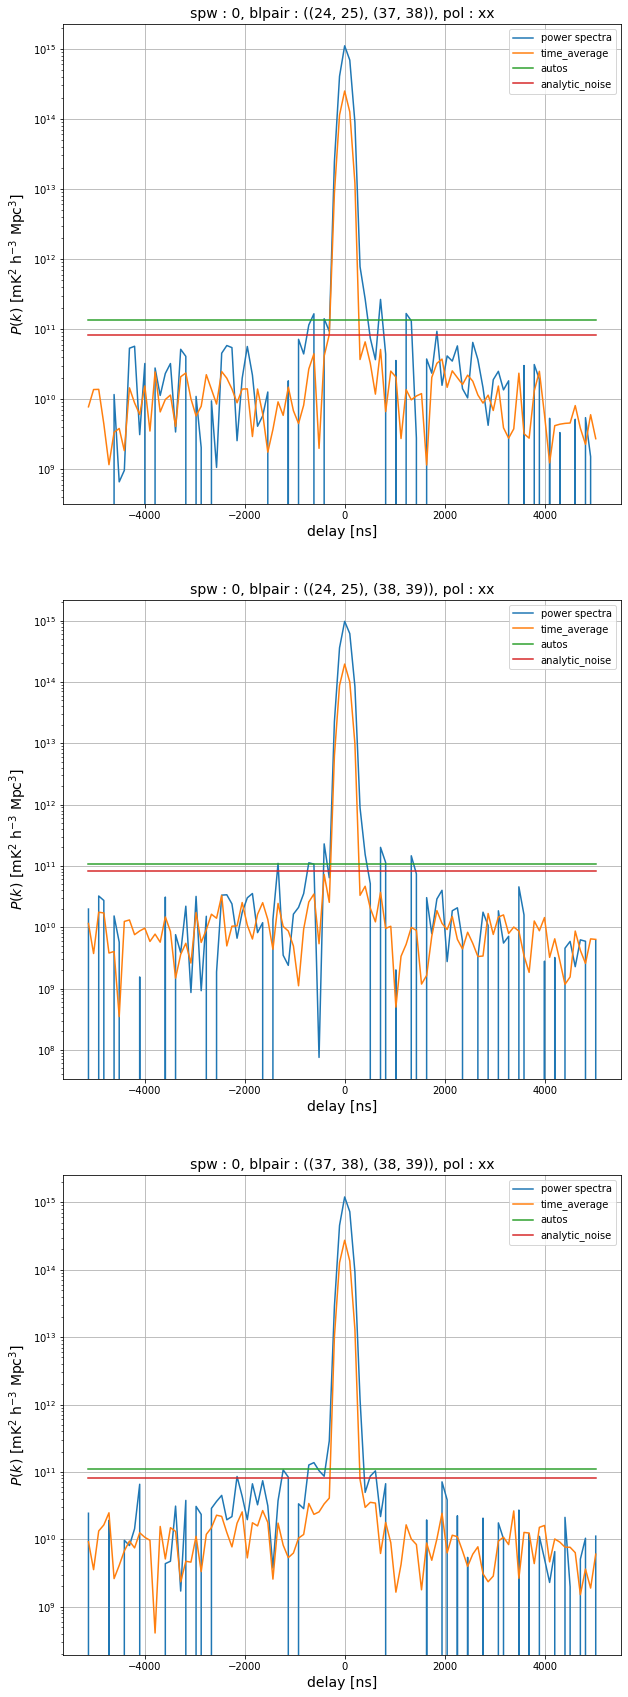

In [11]:
fig, axes = plt.subplots(figsize=(10,30), nrows=3)
spw = 0
dlys = uvp.get_dlys(spw) * 1e9
time_index = 0
Tsys=220
## The system temperature here is not the true system temperature, just an arbitrary input.

for ax_idx in range(3): 
    ax = axes[ax_idx]
    blp = blpairs[ax_idx]
    key = (spw, blp, 'xx')
    ax.plot(dlys, np.real(uvp.get_data(key))[time_index], label="power spectra")
    ax.plot(dlys, np.sqrt(np.abs(np.diag(uvp.get_cov(key,component='real', cov_model="time_average")[time_index]))), label="time_average")
    ax.plot(dlys, np.sqrt(np.abs(np.diag(uvp.get_cov(key,component='real', cov_model="autos")[time_index]))), label="autos") 
    ax.plot(dlys, uvp.generate_noise_spectra(key[0], key[2], Tsys)[uvp.antnums_to_blpair(key[1])][time_index], label="analytic_noise")
    ax.set_yscale('log')
    ax.grid()
    ax.set_xlabel("delay [ns]", fontsize=14)
    ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
    ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)
    ax.legend(loc='best')

The error bars shown above are just for the purpose of code-running examples. 

### Using exact norm:

In [12]:
uvp_exact_norm, uvp_exact_norm_q = ds.pspec(baselines1, baselines2, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400)], input_data_weight='identity',
               norm='I', store_cov=True, exact_norm=True, cov_models=["time_average","autos"], taper='blackman-harris', verbose=False)

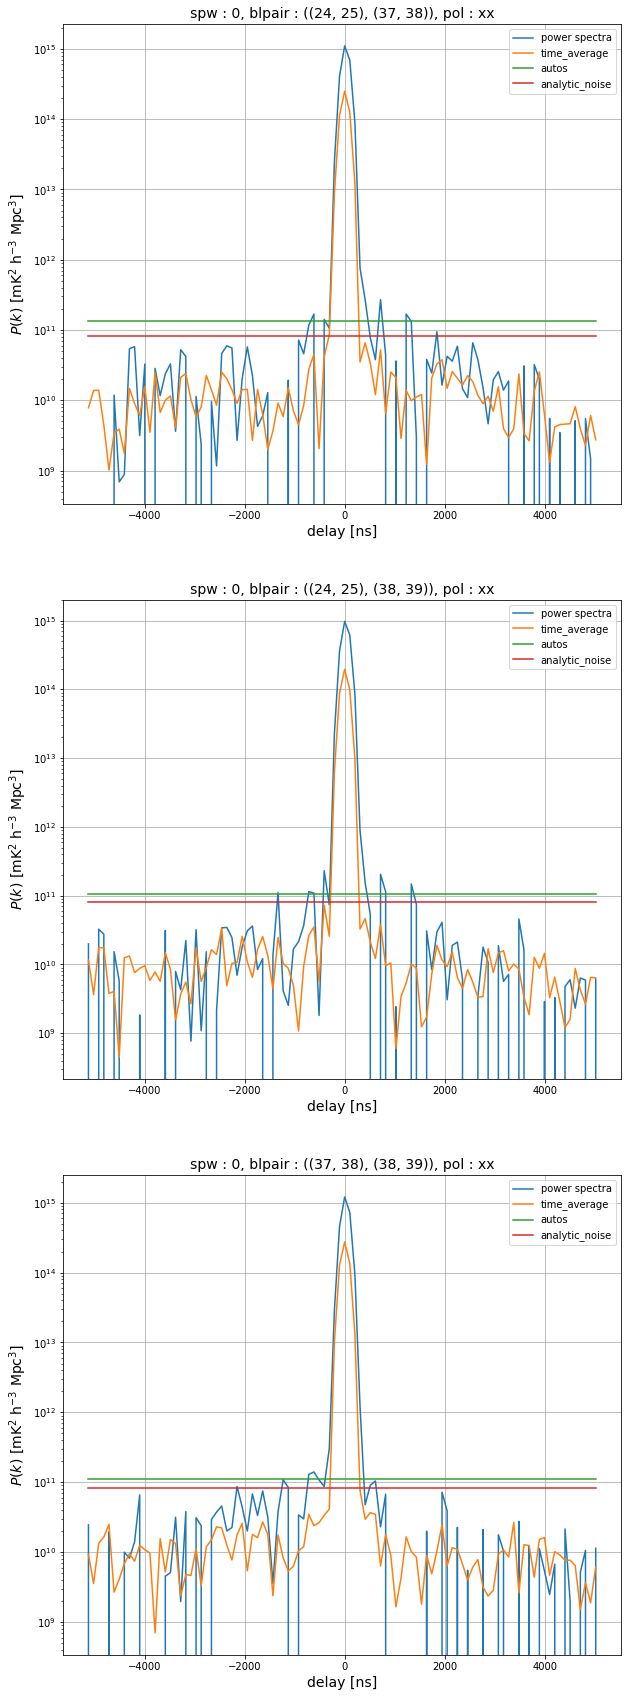

In [13]:
fig, axes = plt.subplots(figsize=(10,30), nrows=3)
spw = 0
dlys = uvp_exact_norm.get_dlys(spw) * 1e9
time_index = 0
Tsys=220
## The system temperature here is not the true system temperature, just an arbitrary input.

for ax_idx in range(3): 
    ax = axes[ax_idx]
    blp = blpairs[ax_idx]
    key = (spw, blp, 'xx')
    ax.plot(dlys, np.real(uvp_exact_norm.get_data(key))[time_index], label="power spectra")
    ax.plot(dlys, np.sqrt(np.abs(np.diag(uvp_exact_norm.get_cov(key,component='real', cov_model="time_average")[time_index]))), label="time_average")
    ax.plot(dlys, np.sqrt(np.abs(np.diag(uvp_exact_norm.get_cov(key,component='real', cov_model="autos")[time_index]))), label="autos") 
    ax.plot(dlys, uvp_exact_norm.generate_noise_spectra(key[0], key[2], Tsys)[uvp_exact_norm.antnums_to_blpair(key[1])][time_index], label="analytic_noise")
    ax.set_yscale('log')
    ax.grid()
    ax.set_xlabel("delay [ns]", fontsize=14)
    ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
    ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)
    ax.legend(loc='best')

The error bars shown above are just for the purpose of code-running examples. 